# **Word2Vec**
Skip-gram model
- Data Preparation
- Model Architecture
- Training

Train a Pre-Implemented W2V
- Data Preparation
- Training (with one line)

Use a Pre-Trained Model
- Download pre-computed vector embeddings
- Make operations with them

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

dtype = torch.FloatTensor
torch.manual_seed(42)
np.random.seed(42)


sentences = ['The future king is the prince',
             'Daughter is the future princess',
             'Son is the prince', 'Only a man can be a king',
             'Only a woman can be a queen',
             'The princess will be a queen',
             'The prince is a strong boy',
             'The princess is a beautiful girl',
             'The princess will be a beautiful woman',
             'Prince is only a boy now',
             'Prince will be king',
             'A boy will be a man',
             'The Man will be a strong king']



# Data preparation

Let's create:
- word_sequence = a list of all the words in our training corpus
- word_list = a list of the unique words of our corpus. This is also known as our **Vocabulary**
- word_dict = a dictionary mapping each word to an integer. This is a mandatory passage for every neural model. Words have to be mapped to integer in the first place. These are called *word IDs*

In [ ]:
# list all the words present in our corpus
word_sequence = " ".join(sentences).lower().split()
# build the vocabulary
word_list = list(set(word_sequence))
# a dictionary mapping each word to an integer
word_dict = {w: i for i, w in enumerate(word_list)}

#store the length of the vocabulary (we will need it later when creating our architecture)
voc_size = len(word_list)


print(f"We have {len(word_sequence)} total words in our corpus:\n {word_sequence}\n")
print(f"We have {len(word_list)} UNIQUE words in our corpus: \n {word_list}\n")
print(f"Mapping between words and their ID: \n{word_dict} \n")


We have 77 total words in our corpus:
 ['the', 'future', 'king', 'is', 'the', 'prince', 'daughter', 'is', 'the', 'future', 'princess', 'son', 'is', 'the', 'prince', 'only', 'a', 'man', 'can', 'be', 'a', 'king', 'only', 'a', 'woman', 'can', 'be', 'a', 'queen', 'the', 'princess', 'will', 'be', 'a', 'queen', 'the', 'prince', 'is', 'a', 'strong', 'boy', 'the', 'princess', 'is', 'a', 'beautiful', 'girl', 'the', 'princess', 'will', 'be', 'a', 'beautiful', 'woman', 'prince', 'is', 'only', 'a', 'boy', 'now', 'prince', 'will', 'be', 'king', 'a', 'boy', 'will', 'be', 'a', 'man', 'the', 'man', 'will', 'be', 'a', 'strong', 'king']

We have 21 UNIQUE words in our corpus: 
 ['only', 'boy', 'son', 'queen', 'is', 'strong', 'man', 'prince', 'be', 'future', 'daughter', 'will', 'princess', 'now', 'a', 'the', 'girl', 'beautiful', 'woman', 'king', 'can']

Mapping between words and their ID: 
{'only': 0, 'boy': 1, 'son': 2, 'queen': 3, 'is': 4, 'strong': 5, 'man': 6, 'prince': 7, 'be': 8, 'future': 9, 'daug

## Skip-Grams



We need to create an integer representation of our skip-grams.
That is to say contexts for each target word. The picture below shows a simple example with a size of 2.
![alt text](http://mccormickml.com/assets/word2vec/training_data.png)

*Picture from https://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/*


Here, for the sake of simplicity we are going to create skip-grams of size 1. This means that for each target word $t$ we will encode the word $t-1$ and $t+1$

This means we will have couples of words like the following:

($t$, $t+1$)

($t$, $t-1$)

As shown in the picture above but with a different window size.

In [ ]:
# Make skip gram of one size window
skip_grams = []
for i in range(1, len(word_sequence) - 1):
    input = word_dict[word_sequence[i]]
    context = [word_dict[word_sequence[i - 1]], word_dict[word_sequence[i + 1]]]

    for w in context:
        skip_grams.append([input, w])

skip_grams[:6]

[[9, 15], [9, 19], [19, 9], [19, 4], [4, 19], [4, 15]]

In [ ]:
for i in range(len(word_sequence[:5])):
  print(f"Target word: {word_sequence[i]}")

  print(f"Context Words: {word_sequence[i - 1]} {word_sequence[i + 1]}")
  print(f"Target word id: {word_dict[word_sequence[i]]}")
  print(f"Context words ids: {word_dict[word_sequence[i - 1]]} {word_dict[word_sequence[i + 1]]}")
  print("\n")


Target word: the
Context Words: king future
Target word id: 15
Context words ids: 19 9


Target word: future
Context Words: the king
Target word id: 9
Context words ids: 15 19


Target word: king
Context Words: future is
Target word id: 19
Context words ids: 9 4


Target word: is
Context Words: king the
Target word id: 4
Context words ids: 19 15


Target word: the
Context Words: is prince
Target word id: 15
Context words ids: 4 7




## One-Hot encoding

The input data must be encoded as a one-hot vector.


This allows the selection of the correct row later when we have
![alt-text](https://mccormickml.com/assets/word2vec/matrix_mult_w_one_hot.png)

In [ ]:
#instantiate an empty vector to be populated as one-hot
onehot_data = np.zeros((voc_size, voc_size))

for i in range(voc_size):
    onehot_data[i][i] = 1

onehot_dict = {}
counter = 0
for word in word_dict:
    onehot_dict[word] = onehot_data[counter]
    counter += 1
pd.DataFrame(onehot_dict.values(), index = onehot_dict.keys()).astype(int).style.background_gradient()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
only,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
boy,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
son,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
queen,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
is,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
strong,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
man,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
prince,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
be,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
future,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
np.random.seed(172)
# we use this function to select portion of the training data and automatically generate 1-hot vecs
def random_batch(data, size):
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(data)), size, replace=False)

    for i in random_index:
        # one-hot encoding of words
        random_inputs.append(np.eye(voc_size)[data[i][0]])
        random_labels.append(data[i][1])  # context word

    random_inputs = torch.Tensor(np.array(random_inputs))
    random_labels = torch.LongTensor(np.array(random_labels))
    return random_inputs, random_labels

random_batch(skip_grams, size=3)

(tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
          0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0.]]),
 tensor([ 0,  8, 15]))

# Model Architecture


There is no activation function on the hidden layer neurons, but the output neurons use softmax.

![alt text](http://mccormickml.com/assets/word2vec/skip_gram_net_arch.png)

*Picture from https://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/*


To create the Word2Vec model architecture we need to set two hyperparameters:
- voc_size = the length of our vocabulary.
- embedding_size = the desired size of our embeddings


*Note:
Larger embedding can be more expressive, but require more text to be trained!*

In [ ]:
# Model
embedding_size = 2
class Word2Vec(nn.Module):
    def __init__(self):
        super(Word2Vec, self).__init__()

        #instantiate layers
        self.W = nn.Parameter(torch.rand(voc_size, embedding_size)).type(dtype) #weights for the inner representation
        self.V = nn.Parameter(torch.rand(embedding_size, voc_size)).type(dtype) #weights for the output representation

    # forward pass
    def forward(self, X):
        # compute the inner representation input* hidden_layer_weights [voc_size, embedding_size]
        hidden_layer = torch.matmul(X, self.W)
        # compute the output values [voc_size]
        output_layer = torch.matmul(hidden_layer, self.V)
        return output_layer

model = Word2Vec()


# Model Training



The model needs to undergo a training loop to learn the parameters for each word, that we can later use as our word embeddings.

## Model Hyperparameters
We decide first a number of hyperparameters needed to train the network, such as:
- $N$ of epochs to train the model for
- batch_size = how many examples at a time we want to feed our model with?
- loss function = This will calculate the error rate of our model's predictions and let it knows how still far from correct it is.
- optimizer = It will update the weights through back propagation following the gradient descent
- learning rate = The rate ("speed") at which we want the model to update its weights


In [ ]:
#N epochs
epochs = 5000
#size of batch passed to the model during training
batch_size = 20

# choose a loss function and an optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



##Training Loop
Once we have decided all this, we can launch the training loop.
To do so we need:
- To instantiate a loop over a number $N$ of epochs
- Feed the model with our input data (target word) and the repsective "labels" (context words).
- Calculate the loss to
- Send the error back through back-propagation
- Update the weights

The cycle is repeated for the number $N$ of epochs we chose in advance

In [ ]:

# Training
model.train() # Set the model in train mode (required by pytorch)
for epoch in range(epochs):

    # we extract a batch of inputs and relative targets
    input_batch, target_batch = random_batch(skip_grams, batch_size)

    # get the model predictions with a forward pass
    output = model(input_batch)

    # calculate the loss between predictions and targets
    loss = loss_fn(output, target_batch)

    if (epoch + 1)%1000 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

    # Back propagation throuch gradient descent
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch: 1000 cost = 2.173845
Epoch: 2000 cost = 2.413773
Epoch: 3000 cost = 2.404031
Epoch: 4000 cost = 2.233962
Epoch: 5000 cost = 2.292958


Let's try to visualize the learned embeddings in the semantic space...

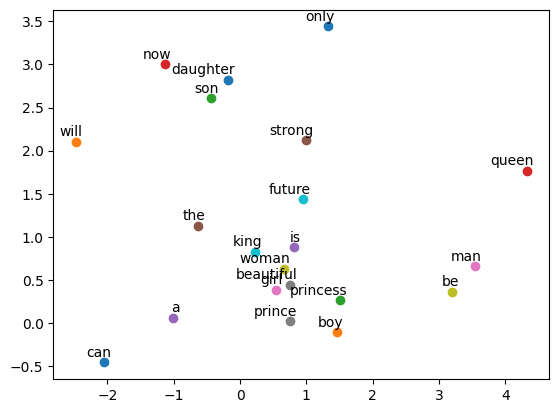

In [ ]:
# Learned W
W, _= model.parameters()
# print(W)
for i, word in enumerate(word_list):
    W, _= model.parameters()
    x,y = float(W[i][0]), float(W[i][1])
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
plt.show()

... this is quite BAD!

The corpus is too small to allow the model to learn something informative. It was just a toy example.

Let's try to train a pre-implemented model on a bigger corpus

### Tools for Viz (skip)

In [ ]:
def tsne_emb_plot(embeddings, emb_dict):
  tsne_model_en_2d = TSNE(perplexity=embeddings.shape[0]-1, n_components=2, init='pca', n_iter=3500, random_state=32).fit_transform(embeddings)
  for emb in tsne_model_en_2d:
    x = embeddings[:, 0]
    y = embeddings[:, 1]
    plt.scatter(x, y)
    for i, word in enumerate(emb_dict):
      plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                    textcoords='offset points', ha='right', va='bottom', size=8)

# raw plot of similar embeddings
def plot_similar(target_word: str):
  words = [w[0] for w in w2v_model.wv.most_similar(target_word)] + [target_word]
  target_embs = {}

  for w in words:
    target_embs[w] = w2v_model.wv[w]

  embeddings = np.array(list(target_embs.values()))
  tsne_emb_plot(embeddings,target_embs)





# **Train a pre-implemented Word2Vec**


Through the [Gensim](https://github.com/RaRe-Technologies/gensim/#documentation) library we can instantiate a W2V model and train it on our own data.



In [ ]:
# import of necessary libraries and download of the text
import nltk
nltk.download("punkt")
from nltk import word_tokenize,sent_tokenize
from gensim.models import Word2Vec
import requests
import os
url = "http://www.gutenberg.org/files/2600/2600-0.txt"
text = requests.get(url).content.decode()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


The only data preparation step we need here is to *tokenize* our corpus.

That means we have to split the text into sentences and words.

We do that with the NLTK library here, but it can be done with whatever method you like.




In [ ]:
#divide the text into sentences...
text_sents = sent_tokenize(text)
print(text_sents[5:8], end = " ")

#...and the sentences into tokens
words = [word_tokenize(s) for s in text_sents]
print("\n", words[5:8], end = " ")

['But how do you do?', 'I see I\r\nhave frightened you—sit down and tell me all the news.”\r\n\r\nIt was in July, 1805, and the speaker was the well-known Anna Pávlovna\r\nSchérer, maid of honor and favorite of the Empress Márya Fëdorovna.', 'With these words she greeted Prince Vasíli Kurágin, a man of high\r\nrank and importance, who was the first to arrive at her reception.'] 
 [['But', 'how', 'do', 'you', 'do', '?'], ['I', 'see', 'I', 'have', 'frightened', 'you—sit', 'down', 'and', 'tell', 'me', 'all', 'the', 'news.', '”', 'It', 'was', 'in', 'July', ',', '1805', ',', 'and', 'the', 'speaker', 'was', 'the', 'well-known', 'Anna', 'Pávlovna', 'Schérer', ',', 'maid', 'of', 'honor', 'and', 'favorite', 'of', 'the', 'Empress', 'Márya', 'Fëdorovna', '.'], ['With', 'these', 'words', 'she', 'greeted', 'Prince', 'Vasíli', 'Kurágin', ',', 'a', 'man', 'of', 'high', 'rank', 'and', 'importance', ',', 'who', 'was', 'the', 'first', 'to', 'arrive', 'at', 'her', 'reception', '.']] 

We can pass the tokenized text to the model instance along with the parameters we choose to adopt.

They are:

- **vector_size** =  the desired size of our resulting vector.
- **window** = the size we want our context to be.
- **min_count** = the minumum frequency of a word to be considered in the training phase
- **sg** = this can be either 0 for CBoW or 1 for Skip-Gram.
- **epochs** = the number of iterations we want to train the model for

*Actual training is just one line of code!*

In [ ]:
# train a W2V with one line of code!
w2v_model = Word2Vec(words, vector_size=100, window=10, min_count=5, sg=1, epochs=20)

We can then try our trained model!

In [ ]:
w2v_model.wv.most_similar("said")

[('replied', 0.7915651798248291),
 ('added', 0.7652410864830017),
 ('remarked', 0.7180930376052856),
 ('cried', 0.7066227197647095),
 ('answered', 0.6924808025360107),
 ('muttered', 0.6809747815132141),
 ('“', 0.6747702360153198),
 ('exclaimed', 0.6562153697013855),
 ('”', 0.6439222097396851),
 ('frighten', 0.6333034634590149)]

In [ ]:
pd.DataFrame(w2v_model.wv["said"]).T

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.261579,-0.056708,0.11352,0.023258,0.203843,-0.149372,0.026935,-0.008336,0.492376,0.315202,...,-0.0619,0.239551,-0.191698,-0.19359,0.056431,0.075809,0.03363,0.306335,0.36985,0.006973


In [ ]:
print(w2v_model.wv.most_similar("went"))
print(w2v_model.wv.most_similar("house"))

[('tiptoe', 0.6048173904418945), ('glided', 0.6036017537117004), ('paced', 0.5548338890075684), ('returned', 0.5496895909309387), ('strode', 0.5455070734024048), ('Going', 0.5419564843177795), ('ran', 0.5410280227661133), ('go', 0.5409407019615173), ('came', 0.5319349765777588), ('turned', 0.519835352897644)]
[('Razumóvskis', 0.6305042505264282), ('Mass', 0.6136383414268494), ('Povarskáya', 0.6115189790725708), ('courtyard', 0.6050076484680176), ('Bazdéev', 0.602484941482544), ('houses', 0.5967074036598206), ('widow', 0.5870248079299927), ('apartments', 0.5863509774208069), ('adjoining', 0.5815850496292114), ('avenue', 0.5689811110496521)]


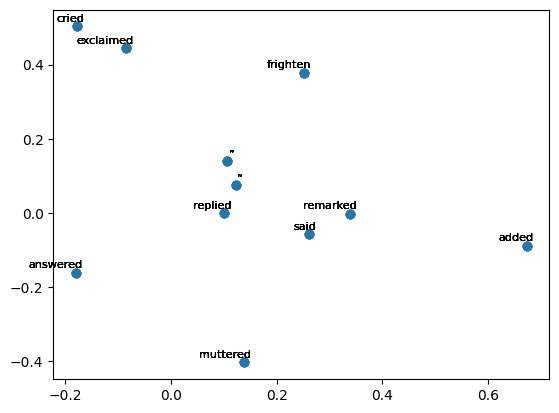

In [ ]:
# plot similar to said
plot_similar("said")

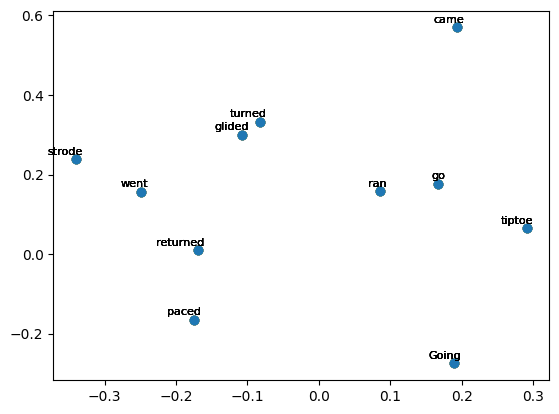

In [ ]:
plot_similar("went")

In [ ]:
print(w2v_model.wv.most_similar("prince"))

[('architect', 0.6850099563598633), ('princess', 0.6063088178634644), ('Dessalles', 0.5475552678108215), ('Tíkhon', 0.5444397926330566), ('nurses', 0.5433584451675415), ('Dron', 0.5412311553955078), ('gardener', 0.5390490293502808), ('old', 0.5367709994316101), ('count', 0.5308640003204346), ('doctor', 0.5297840237617493)]


---
# **Using a (well!!) pre-trained model**

We are going to use pre-trained embeddings to do some practical manipulations with them.

We use [GloVe](https://nlp.stanford.edu/projects/glove/) through the [gensim](https://github.com/RaRe-Technologies/gensim/#documentation) library.

GloVe is an unsupervised learning algorithm for obtaining vector representations for words.

You can think of it as an improved version of Word2Vec, but with the same underlying theoretical principles.

Through Gensim, we can download a pre-trained English embedding that was trained on Wikipedia and others open datasets.

*keyed vectors*

In [ ]:
# load pre-trained word-vectors from gensim-data
import gensim.downloader as api
glove_model = api.load("glove-wiki-gigaword-100")

[==================================================] 100.0% 128.1/128.1MB downloaded


## (Word) Vector Operations
We can do a bunch of stuff with this pre-trained embedding model.

Let's see some examples.


We can choose a word and look for the most similar other words in the corpus.

Similarity between vectors can be computed in various way, but usually we stick with *cosine similarity*

In [ ]:
print(glove_model.most_similar('airplane'))
print("\n")
print(glove_model.most_similar('sea'))

[('plane', 0.8651753664016724), ('jet', 0.8155896663665771), ('aircraft', 0.7861484289169312), ('airplanes', 0.7662243843078613), ('airliner', 0.7646356225013733), ('jetliner', 0.7469576597213745), ('flight', 0.7339501976966858), ('planes', 0.7338765263557434), ('flying', 0.7300053834915161), ('crash', 0.7099080085754395)]


[('ocean', 0.8386560678482056), ('waters', 0.8161073327064514), ('seas', 0.7600179314613342), ('mediterranean', 0.725997805595398), ('arctic', 0.6975978016853333), ('coast', 0.6973382830619812), ('atlantic', 0.6909533143043518), ('coastal', 0.6893701553344727), ('ship', 0.6781935095787048), ('gulf', 0.6579796075820923)]


In [ ]:
glove_model.most_similar("helicopter")

[('helicopters', 0.8704310059547424),
 ('plane', 0.7729538083076477),
 ('aircraft', 0.752933919429779),
 ('planes', 0.7295040488243103),
 ('pilot', 0.7184426784515381),
 ('jet', 0.7124884128570557),
 ('gunship', 0.7097162008285522),
 ('flew', 0.7094025611877441),
 ('gunships', 0.706062376499176),
 ('crashed', 0.7038615345954895)]

In [ ]:
result = glove_model.most_similar(positive=['helicopter', 'wings'])
print("{}: {:.4f}".format(*result[0]))

aircraft: 0.7484


In [ ]:
result = glove_model.most_similar(positive=['plane'], negative=['wings'])
print("{}: {:.4f}".format(*result[0]))
#result

crash: 0.5087


In [ ]:
result = glove_model.most_similar(positive=['adult', "male"], negative=['men'])
print("{}: {:.4f}".format(*result[0]))
#result

female: 0.6810


In [ ]:
result = glove_model.most_similar(positive=['adult', "female"], negative=['woman'])
print("{}: {:.4f}".format(*result[0]))

male: 0.7299


In [ ]:
result = glove_model.most_similar(positive=['woman', 'king'], negative=['man'])  # vector(woman) + vector(king) - vector(man)
print("{}: {:.4f}".format(*result[0]))

result = glove_model.most_similar(positive=['man', 'queen'], negative=['woman'])
print("{}: {:.4f}".format(*result[0]))

queen: 0.7699
king: 0.7976


In [ ]:
result = glove_model.most_similar(positive=['thames', 'paris'], negative=['london'])
print("{}: {:.4f}".format(*result[0]))

seine: 0.6995


##Check for biases

Unfortunatly, one of the clearest clue of the real working of embeddings is their encoding of cultural biases.

In [ ]:
result = glove_model.most_similar(positive=['woman', 'doctor'], negative=['man'])
print("{}: {:.4f}".format(*result[0]))



nurse: 0.7735


In [ ]:
result = glove_model.most_similar(positive=['man', 'doctor'], negative=['woman'])
print("{}: {:.4f}".format(*result[0]))

dr.: 0.6559


In [ ]:
result = glove_model.most_similar(positive=['man', 'nurse'], negative=['woman'])
print("{}: {:.4f}".format(*result[0]))



doctor: 0.7209


In [ ]:
result = glove_model.most_similar(positive=['woman', 'nurse'], negative=['man'])
print("{}: {:.4f}".format(*result[0]))

nurses: 0.6930


##Intruder detection

We can find which word is the "intruder" in a list of words. This means the intruder is not semantically related with the others and this is captured by the model

In [ ]:
print(glove_model.doesnt_match("breakfast cereal dinner lunch".split()))




cereal


In [ ]:
print(glove_model.doesnt_match("obama kennedy trump dylan".split()))


dylan


In [ ]:

print(glove_model.doesnt_match("paris milano moscow hamburg madrid cake".split()))



cake


In [ ]:
print(glove_model.doesnt_match('dog fish cow building'.split()))

building


# More visualization

Here we try to visualize some words.

We have two groups of words, one referring to *animals* and the other one to *vehicles*. If we plot their embeddings we expect that words belonging to the same group are represented near each other

*Note*

Keep in mind that this is not an absolute truth but an approximation!

Moreover we have to reduce the dimensionality of the embeddings to plot them in 2D and this may caus a loss of significant information.

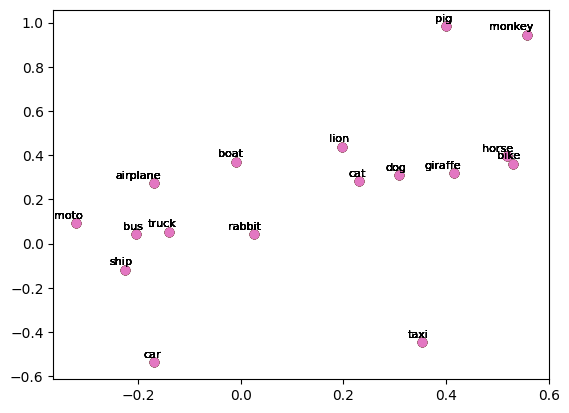

In [ ]:
animals = ["dog", "cat", "rabbit", "monkey", "giraffe", "lion", "horse", "pig"]
vehicles = ["car", "boat", "truck", "bus", "ship", "airplane", "taxi", "bike", "moto"]
all = animals+vehicles

#extract target embedding from glove
emb_dict = {}
for w in all:
  try:
    emb_dict[w] = glove_model[w]
  except:
    print(w)
embeddings = np.array(list(emb_dict.values()))
embeddings.shape
tsne_emb_plot(embeddings,emb_dict)



more or less it seems that animals are with animals and vehicles with vehicles